# **Recommender System for Walmart Product Dataset**

In this notebook, we will be developing 4 different models for diverse recommendation generation for Walmart Product dataset.

1. Rating-based Model
2. Content-based Model: TF-IDF similarity algorithm
3. User-based Collaborative Filtering
- Memory-Based Model
- KNN
- SVD
- SVD++
4. Hybrid Model

In [3]:
!pip install numpy==1.24.4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from scipy.sparse import coo_matrix

In [4]:
df = pd.read_csv('walmart_raw.tsv', sep='\t')

# **Data Cleaning, EDA, and Data Preprocessing**

In [5]:
df["Product Rating"] = df["Product Rating"].apply(lambda x: round(np.random.uniform(0.0, 4.9), 1) if pd.isna(x) else x)
df.loc[df['Product Rating'] < 1, 'Product Rating'] = 1
df["Product Reviews Count"] = df["Product Reviews Count"].apply(lambda x: 1 if x == 0 else x)
df.head()


,Uniq Id,Crawl Timestamp,Dataset Origin,Product Id,Product Barcode,Product Company Type Source,Product Brand Source,Product Brand Normalised Source,Product Name Source,Match Rank,...,Product Currency,Product Available Inventory,Product Image Url,Product Model Number,Product Tags,Product Contents,Product Rating,Product Reviews Count,Bsr,Joining Key
0,1705736792d82aa2f2d3caf1c07c53f4,2020-09-24 03:21:12 +0000,NaN,2e17bf4acecdece67fc00f07ad62c910,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",NaN,2.4,NaN,NaN,81350af1be98d3753cf964709f0c766a
1,95a9fe6f4810fcfc7ff244fd06784f11,2020-10-30 14:04:08 +0000,NaN,076e5854a62dd283c253d6bae415af1f,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,NaN,"Nice 'n Easy Permanent Color, 111 Natural Medi...",NaN,1.9,NaN,NaN,0353e63907dc0de0c734db4690300057
2,8d4d0330178d3ed181b15a4102b287f2,2020-08-06 05:51:47 +0000,NaN,8a4fe5d9c7a6ed26cc44d785a454b124,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,NaN,Clairol Nice 'N Easy Permanent Color 7/106A Na...,NaN,4.5,29221.0,NaN,b6985c8e94815fbca2319dbb8bf228af
3,fddc4df45b35efd886794b261f730c51,2020-07-15 11:22:04 +0000,NaN,03b5fb878a33eadff8b033419eab9669,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/25b4b467-bc61...,NaN,"Kokie Professional Matte Lipstick, Hot Berry, ...",NaN,3.3,NaN,NaN,85b70fded09186f00467cea2f935b779
4,0990cf89a59ca6a0460349a3e4f51d42,2020-11-26T12:27:20+00:00,NaN,ce3d761e57d6ccad80619297b5b1bcbc,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/1a2ebb06-cd01...,NaN,"Gillette TRAC II Plus Razor Blade Refills, Fit...",NaN,4.4,131.0,NaN,41c870871328e97da6fb036bb7d4b2da


In [6]:

columns_to_fill = ['Product Reviews Count', 'Product Category', 'Product Brand', 'Product Description']
df[columns_to_fill[0]].fillna(0,inplace=True)
df[columns_to_fill[1]].fillna('',inplace=True)
df[columns_to_fill[2]].fillna('',inplace=True)
df[columns_to_fill[3]].fillna('',inplace=True)


<ipython-input-6-bc1c6da1cad7>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[columns_to_fill[0]].fillna(0,inplace=True)
<ipython-input-6-bc1c6da1cad7>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [7]:
# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}
# Rename the columns using the mapping
df.rename(columns=column_name_mapping, inplace=True)

In [8]:
df['ID'] = df['ID'].str.extract(r'(\d+)').astype(float)
df['ProdID'] = df['ProdID'].str.extract(r'(\d+)').astype(float)


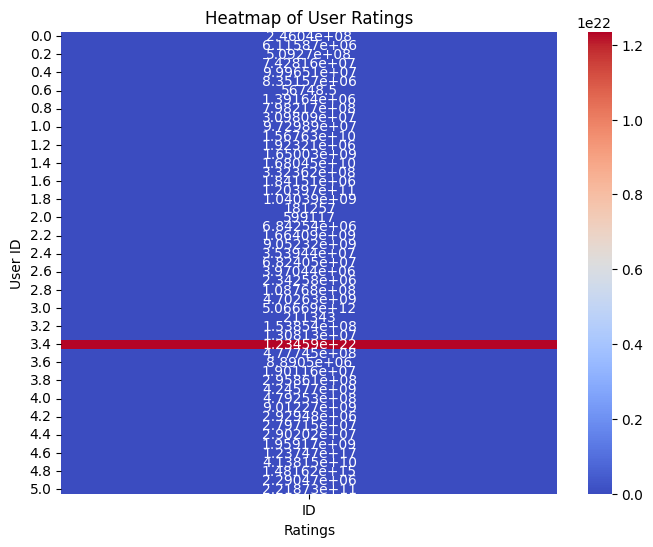

In [9]:
# Pivot the DataFrame to create a heatmap
heatmap_data = df.pivot_table('ID', 'Rating')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

Text(0.5, 1.0, 'Most Popular items')

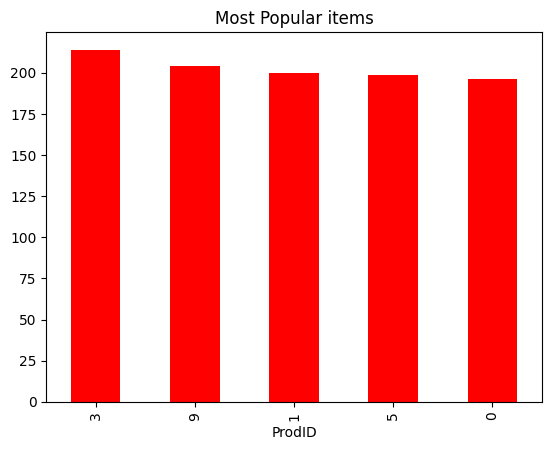

In [10]:
df['ProdID'] = df['ProdID'].astype(int)
popular_items = df['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")


<Axes: xlabel='Rating'>

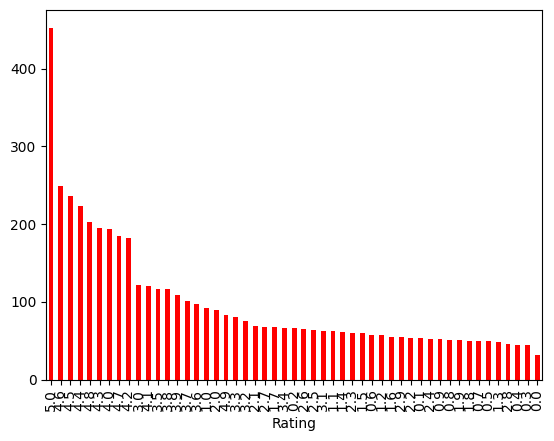

In [11]:
# print most rated counts
df['Rating'].value_counts().plot(kind='bar',color='red')

 We will use columns: category, brand and description to perform recommendation analysis. This is to
remove stop words and non-alphanumeric characters from each data.

In [12]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

# Apply on three columns: Category, Brand and Description
df['p_Category'] = df['Category'].apply(clean_and_extract_tags)
df['p_Brand'] = df['Brand'].apply(clean_and_extract_tags)
df['p_Description'] = df['Description'].apply(clean_and_extract_tags)

In [13]:
columns_to_extract_tags_from = ['p_Category', 'p_Brand', 'p_Description']
df['Tags'] = df[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)
processed = df

# **Rating-Based Recommendation System**

In [117]:
average_ratings = df.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()

In [118]:
top_rated_items = average_ratings.sort_values(by=['Rating', 'ReviewCount'], ascending=[False, False])
top_rated_items.head(10)

,Name,ReviewCount,Brand,ImageURL,Rating
419,"ACT Braces Care Anticavity Mouthwash (18 Oz, C...",32.0,ACT,https://i5.walmartimages.com/asr/a7fa6e41-316f...,5.0
4716,"Versace Man Eau Fraiche Eau De Toilette Spray,...",24.0,Versace,https://i5.walmartimages.com/asr/edaaeed5-9da0...,5.0
4592,Tree Hut Shea Sugar Scrub Passion Fruit & Guav...,22.0,Tree Hut,https://i5.walmartimages.com/asr/be83d31d-81cf...,5.0
850,Biolage Hydrasource Conditioning Balm For Dry ...,21.0,Matrix,https://i5.walmartimages.com/asr/4a0904fb-a101...,5.0
653,"Ardell Double Up False Eyelashes, 203",19.0,Ardell,https://i5.walmartimages.com/asr/7c7534ab-b6ea...,5.0
2168,"Hello Kids Fluoride Free and SLS Free Rinse, N...",19.0,Hello,https://i5.walmartimages.com/asr/6998ff2c-58be...,5.0
3838,"ReNew Life CleanseMore, Veggie Caps, 60 ea",15.0,Renew Life,https://i5.walmartimages.com/asr/9f707fe4-9ee3...,5.0
77,"(2 Pack) Pro Styl Vitamin &quotE&quot Oil, 6 Oz",13.0,V.I.P.,https://i5.walmartimages.com/asr/b31a925f-cb2a...,5.0
710,Aura Cacia Essential Oil Frankincense 0.5 fl o...,13.0,Aura Cacia,https://i5.walmartimages.com/asr/d5261a71-0787...,5.0
1228,Clay-Park Labs Ammonium Lactate Lotion 12% 14 ...,13.0,Clay-Park Labs,https://i5.walmartimages.com/asr/b3d5462d-d067...,5.0


In [19]:
rating_base_recommendation = top_rated_items.head(10)
rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)

<ipython-input-19-5c6b1af8e985>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
<ipython-input-19-5c6b1af8e985>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)


In [20]:
# Trending Items Recommendation by Rating and Review Counts
rating_base_recommendation.head()

,Name,ReviewCount,Brand,ImageURL,Rating
419,"ACT Braces Care Anticavity Mouthwash (18 Oz, C...",32,ACT,https://i5.walmartimages.com/asr/a7fa6e41-316f...,5
4716,"Versace Man Eau Fraiche Eau De Toilette Spray,...",24,Versace,https://i5.walmartimages.com/asr/edaaeed5-9da0...,5
4592,Tree Hut Shea Sugar Scrub Passion Fruit & Guav...,22,Tree Hut,https://i5.walmartimages.com/asr/be83d31d-81cf...,5
850,Biolage Hydrasource Conditioning Balm For Dry ...,21,Matrix,https://i5.walmartimages.com/asr/4a0904fb-a101...,5
653,"Ardell Double Up False Eyelashes, 203",19,Ardell,https://i5.walmartimages.com/asr/7c7534ab-b6ea...,5


# **Content-based Recommendation System**

We first perform tf-idf transformation to transform tags into numerical matrix. Then, use cosine similarity to calculate the similarity between all pairs of items in our vectors.

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(df['Tags'])
cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)

In [122]:
df['Name']

,Name
0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,"Nice n Easy Permanent Color, 111 Natural Mediu..."
2,Clairol Nice N Easy Permanent Color 7/106A Nat...
3,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,"Gillette TRAC II Plus Razor Blade Refills, Fit..."
...,...
4995,"Garden Mint Room Spray (Double Strength), 4 ou..."
4996,Garnier Nutrisse Nourishing Hair Color Creme (...
4997,"Nail File Electric Drill, 6 in 1 Professional ..."
4998,Creed Love In Black Hair And Body Wash 6.8oz/2...


 Find 10 most similar items for item 'Foundation' according to cosine-similarity matrix.

In [123]:
item_index = 458
item_name = df.loc[item_index, 'Name']
print(item_name)
similar_items = list(enumerate(cosine_similarities_content[item_index]))
similar_items = sorted(similar_items, key=lambda x:x[1], reverse=True)
top_similar_items = similar_items[1:10]
recommended_items_indics = [x[0] for x in top_similar_items]
recommended_items = df.iloc[recommended_items_indics]
print('Recommended items for', item_name,':')
print(recommended_items[['Name','Brand','Rating','ReviewCount','Product Price']])
print(list(recommended_items['Name']))

2 Pack - Shea Moisture Organic Coconut & Hibiscus Shea Butter Soap 3.5 oz
Recommended items for 2 Pack - Shea Moisture Organic Coconut & Hibiscus Shea Butter Soap 3.5 oz :
                                                   Name            Brand  \
2949        SheaMoisture Body Lotion - Raw Shea - 13 oz     SheaMoisture   
4422  SheaMoisture KIDS Curling Butter Creme - Cocon...  Nubian Heritage   
3228  SheaMoisture African Black Soap Purification M...     SheaMoisture   
4073  SheaMoisture Head-to-Toe Nourishing Hydration ...     SheaMoisture   
524   SheaMoisture Bath, Body & Massage Oil Coconut ...     SheaMoisture   
3522  Shea Moisture African Black Soap Balancing Moi...     SheaMoisture   
4477  SheaMoisture Hydration Bar Soap 100% Virgin Co...     SheaMoisture   
487         SheaMoisture Bar Soap Raw Shea Butter, 8 oz     SheaMoisture   
1182  Shea Moisture Coconut & Hibiscus Bath, Body & ...     SheaMoisture   

      Rating  ReviewCount  Product Price  
2949     3.7       3285.

**Function for Content-Based Recommendation System**

In [124]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n=10):
    if item_name not in df['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)
    item_index = train_data[train_data['Name'] == item_name].index[0]
    similar_items = list(enumerate(cosine_similarities_content[item_index]))
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)
    top_similar_items = similar_items[1:top_n+1]
    recommended_item_indices = [x[0] for x in top_similar_items]
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating','Product Price']]
    recommended_items_details = recommended_items_details.sort_values(by=['Rating', 'ReviewCount'], ascending=[False, False])

    return recommended_items_details

In [125]:
# Example: Get content-based recommendations for a specific item
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(df, item_name, top_n=8)
content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating,Product Price
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,OPI,https://i5.walmartimages.com/asr/744e869c-3500...,5.0,44.95
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,OPI,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0,44.95
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,OPI,https://i5.walmartimages.com/asr/2d6f5147-53a8...,4.8,45.95
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,OPI,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4,8.67
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,OPI,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,4.0,18.42
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,1.0,OPI,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,3.9,11.95
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,1.0,OPI,https://i5.walmartimages.com/asr/71caed3f-5f83...,1.5,12.95
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,OPI,https://i5.walmartimages.com/asr/7426eb5c-1690...,1.0,8.60


# **Collaborative Filtering**

# **Memory-based Collaborative Filtering (Neighborhood-based)**

Memory-based collaborative filtering is one of the most commonly used approaches in recommendation systems, relying on past user interactions to suggest items. Instead of learning a predictive model, memory-based methods directly use similarity measures to find relationships between users or items in a dataset.

In [56]:
user_item_matrix = df.pivot_table(index='ID', columns='ProdID', values='Rating',aggfunc='mean').fillna(0).astype(int)
user_similarity = cosine_similarity(user_item_matrix)

In [57]:
# to find similar users according to purchasing preference
target_user_id = 4
target_user_index = user_item_matrix.index.get_loc(target_user_id)
user_similarities = user_similarity[target_user_index]
similar_user_indices = user_similarities.argsort()[::-1][1:]
print(similar_user_indices)

[  28    9   84 ...  591 1141 1720]


In [58]:
# Look for items that similar users have rated but target users have not rated. These items are then considered
# as potential recommendations, with maximum 10 recs. The final list returns all item IDs that are likely
# to be of interest to the target user based on the preferences of similar users.
recommend_items = []
for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)
    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommended_items_details = df[df['ProdID'].isin(recommend_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating','Product Price']]
print(recommended_items_details.head(10))

                                                  Name  ReviewCount  \
31   Head & Shoulders Dandruff Conditioner Dry Scal...          0.0   
37              Wahl Color Pro Plus Haircut Kit 79752T        388.0   
40   Pantene Pro-V Repairing Mask Treatment, Gold S...        176.0   
56                       Grisi Soap - Avena Oat 3.5 Oz          0.0   
58            Humco Holding Group Glycerin, 16 Fl. Oz.          1.0   
86   LOreal Paris Feria Multi-Faceted Shimmering Pe...       2144.0   
108  OPI Nail Dipping Powder Perfection Combo - Liq...          1.0   
128  Navitas Organics, Organic, Goji Berries, 16 oz...          0.0   
144  Covidien Curity Maternity Pad Heavy 4.33&quot ...          0.0   
147  Olay Complete Daily Moisturizer for Sensitive ...        737.0   

                Brand                                           ImageURL  \
31   Head & Shoulders  https://i5.walmartimages.com/asr/a924d53f-007d...   
37               Wahl  https://i5.walmartimages.com/asr/244aef35-a

**Function for Memory-Based Algorithm**

In [98]:
def memory_based_one_recommendations(train_data, target_user_id, top_n=10):
    # Create user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Compute user similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Get target user index
    target_user_index = user_item_matrix.index.get_loc(target_user_id)
    user_similarities = user_similarity[target_user_index]

    # Get similar users (excluding the target user)
    similar_users_indices = np.argsort(-user_similarities)[1:]  # Descending order

    recommended_items = set()

    # Iterate over similar users
    for user_index in similar_users_indices:
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user > 0) & (user_item_matrix.iloc[target_user_index] == 0)

        recommended_items.update(user_item_matrix.columns[not_rated_by_target_user])
        if len(recommended_items) >= top_n:
            break

    # Convert to list and limit to top_n
    recommended_items = list(recommended_items)[:top_n]

    # Fetch item details and remove duplicates
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)].drop_duplicates(subset=['ProdID'])
    print(len(recommended_items))

    return recommended_items_details[['ProdID','Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating','Product Price']].head(top_n)


Evaluation by RMSE

In [96]:
def memory_based_two_recommendations(train_data, target_user_id, top_n=10):
    # Create user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)
    user_similarity = cosine_similarity(user_item_matrix)

    # Check if target_user_id exists in the matrix index
    if target_user_id not in user_item_matrix.index:
        print(f"User ID {target_user_id} not found in training data. Returning empty recommendations.")
        return pd.DataFrame()  # Return empty DataFrame if user not found

    # Get target user index
    target_user_index = user_item_matrix.index.get_loc(target_user_id)
    user_similarities = user_similarity[target_user_index]

    # Get similar users (excluding the target user)
    similar_users_indices = np.argsort(-user_similarities)[1:]  # Descending order

    recommended_items = set()

    # Iterate over similar users
    for user_index in similar_users_indices:
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user > 0) & (user_item_matrix.iloc[target_user_index] == 0)

        recommended_items.update(user_item_matrix.columns[not_rated_by_target_user])
        if len(recommended_items) >= top_n:
            break

    recommended_items = list(recommended_items)[:top_n]

    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)].drop_duplicates(subset=['ProdID'])
    return recommended_items_details[['ProdID','Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating','Product Price']].head(top_n)

def evaluate_rmse(train_data, test_data):
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Compute user similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Store true ratings and predicted ratings
    actual_ratings = []
    predicted_ratings = []

    for _, row in test_data.iterrows():
        user_id = row['ID']
        prod_id = row['ProdID']
        actual_rating = row['Rating']

        # Check if the user and product exist in the training data
        if user_id not in user_item_matrix.index or prod_id not in user_item_matrix.columns:
            continue  # Skip if user or product not in training data

        target_user_index = user_item_matrix.index.get_loc(user_id)
        user_similarities = user_similarity[target_user_index]

        # Get top similar users
        similar_users_indices = np.argsort(-user_similarities)[1:6]  # Top 5 similar users

        # Predict rating using weighted sum
        weighted_sum = 0
        sim_sum = 0

        for user_index in similar_users_indices:
            sim_score = user_similarities[user_index]
            user_ratings = user_item_matrix.iloc[user_index]

            if prod_id in user_ratings and user_ratings[prod_id] > 0:
                weighted_sum += sim_score * user_ratings[prod_id]
                sim_sum += abs(sim_score)

        if sim_sum > 0:
            predicted_rating = weighted_sum / sim_sum
        else:
            predicted_rating = user_item_matrix.mean().mean()  # Default to global mean

        actual_ratings.append(actual_rating)
        predicted_ratings.append(predicted_rating)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    return rmse
train_data = df.sample(frac=0.8, random_state=42)  # 80% training
test_data = df.drop(train_data.index)  # 20% test

rmse_score = evaluate_model(train_data, test_data)

User ID 990.0 not found in training data. Returning empty recommendations.
User ID 704.0 not found in training data. Returning empty recommendations.
User ID 6382.0 not found in training data. Returning empty recommendations.
User ID 9350.0 not found in training data. Returning empty recommendations.
User ID 7092.0 not found in training data. Returning empty recommendations.
User ID 709.0 not found in training data. Returning empty recommendations.
User ID 55653.0 not found in training data. Returning empty recommendations.
User ID 51768.0 not found in training data. Returning empty recommendations.
User ID 92592.0 not found in training data. Returning empty recommendations.
User ID 6956489.0 not found in training data. Returning empty recommendations.
User ID 4496.0 not found in training data. Returning empty recommendations.
User ID 1948.0 not found in training data. Returning empty recommendations.
User ID 6027.0 not found in training data. Returning empty recommendations.
User ID 9

The RMSE for memory-based model is 1.9366

In [99]:
# Example usage
target_user_id = 4
collaborative_filtering_rec = memory_based_one_recommendations(df,target_user_id)
print(f"Top 10 recommendations for User {target_user_id}:")
collaborative_filtering_rec

10
Top 10 recommendations for User 4:


,ProdID,Name,ReviewCount,Brand,ImageURL,Rating,Product Price
56,28,Grisi Soap - Avena Oat 3.5 Oz,0.0,Grisi,https://i5.walmartimages.com/asr/aecd4fd9-bfec...,2.0,20.49
108,13,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,OPI,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0,57.95
144,22,Covidien Curity Maternity Pad Heavy 4.33&quot ...,0.0,Covidien,https://i5.walmartimages.com/asr/e4e38217-ed43...,2.7,6.19
162,34,Pantene Pro-V Beautiful Lengths Strengthening ...,0.0,Pantene,https://i5.walmartimages.com/asr/964b1347-0ccb...,2.2,21.24
503,36,Genuine Joe Professional Strength Lemon Dish D...,14.0,Genuine Joe,https://i5.walmartimages.com/asr/89380ddf-baa6...,4.2,16.01
937,26,LOreal Skin Expertise RevitaLift Complete Eye ...,3.0,L'Oreal Paris,https://i5.walmartimages.com/asr/619e9586-31f0...,3.6,30.82
1446,80412,CND Ridgefx Nail Surface Enhancer .5 Fl Oz.,2.0,CND,https://i5.walmartimages.com/asr/b8f978f5-77ae...,4.7,6.80
1545,2270737,Davines Mask Hair Cream Hair Color W. Vibrachr...,0.0,Davines,https://i5.walmartimages.com/asr/63a75fba-58a0...,3.3,12.95
3686,535,"MD Science Lab Hand Sanitizer Spray, BZK, Fres...",3.0,MD Science Lab,https://i5.walmartimages.com/asr/1888ae12-4867...,1.0,19.99
3799,81351967241,CND Creative Nail Gel Polish Shellac Combo - B...,1.0,CND,https://i5.walmartimages.com/asr/06097bd9-5429...,2.2,44.95


# **KNN-Based Collaborative Filtering**

K-Nearest Neighbors (KNN) is a popular memory-based approach used in collaborative filtering recommendation systems. It works by finding the most similar users or items based on historical interactions and using them to make predictions. KNN is effective for both user-based and item-based collaborative filtering.

In [77]:
from surprise.model_selection import train_test_split
from surprise import Dataset, Reader, KNNBasic
from surprise import accuracy# Define rating scale (1 to 5)
reader = Reader(rating_scale=(1, 5))

# Load dataset into Surprise format
data = Dataset.load_from_df(df[['ID', 'ProdID', 'Rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
# Define similarity options
sim_options = {
    'name': 'cosine',     # Use cosine similarity
    'user_based': True,    # Use user-based collaborative filtering
    'min_support': 1,     # Minimum number of common items for similarity calculation (default is 1)
    'shrinkage': 100      # Shrinkage factor to avoid overfitting (default is 100)
}

# Create and train the model
knn = KNNBasic(sim_options=sim_options)
knn.fit(trainset)
pred = knn.predict(uid=1, iid=104)
print(pred)


Computing the cosine similarity matrix...
Done computing similarity matrix.
user: 1          item: 104        r_ui = None   est = 3.36   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


In [78]:
# Make predictions on test set
predictions = knn.test(testset)

# Compute RMSE
accuracy.rmse(predictions)

RMSE: 1.4506


1.4505561465338423

We explore different ways to improve KNN model performance. Methods include:
1. Use KNNWithZScore
2. Use Pearson similarity instead of Cosine
3. Tune KNN Hyperparameters (Optimize k)


In [33]:
from surprise import KNNWithZScore,KNNWithMeans

knn_zscore = KNNWithZScore(k=10, sim_options=sim_options)
knn_zscore.fit(trainset)

predictions = knn_zscore.test(testset)
rmse = accuracy.rmse(predictions)
print("RMSE:", rmse)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4664
RMSE: 1.4663682257820845


In [34]:
sim_options = {
    'name': 'pearson',  # Use Pearson similarity instead of cosine
    'user_based': True
}

knn_pearson = KNNWithMeans(k=10, sim_options=sim_options)
knn_pearson.fit(trainset)

predictions = knn_pearson.test(testset)
rmse = accuracy.rmse(predictions)
print("RMSE:", rmse)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5245
RMSE: 1.524519656026219


Cosine similarity might be better than Pearson

Then we proceed to tune the model with best-k hyperparameter tuning. To find the best k for K-Nearest Neighbors (KNN) in a collaborative filtering recommendation system, we can use cross-validation with different values of k and evaluate their RMSE scores.


In [76]:
from surprise import KNNBasic, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
import pandas as pd

# Load dataset (assuming 'data' is a Pandas DataFrame)
reader = Reader(rating_scale=(df['Rating'].min(), df['Rating'].max()))
dataset = Dataset.load_from_df(df[['ID', 'ProdID', 'Rating']], reader)

trainset, testset = train_test_split(dataset, test_size=0.2, random_state=42)

param_grid = {
    'k': [10, 20, 30, 40, 50,60,70],  # Different values of k
    'sim_options': {'name': ['cosine'], 'user_based': [True]}  # Cosine similarity for user-based CF
}

# Perform Grid Search with 5-Fold Cross-Validation
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
gs.fit(dataset)

# Print RMSE results for all k values
print("\nRMSE for different k values:")
for params, result in zip(gs.cv_results['params'], gs.cv_results['mean_test_rmse']):
    print(f"k = {params['k']} -> RMSE: {result:.4f}")
best_k = gs.best_params['rmse']['k']
print("\nBest k:", best_k)

# Train the final KNN model using the best k
knn = KNNBasic(k=best_k, sim_options={'name': 'cosine', 'user_based': True})
trainset = dataset.build_full_trainset()
knn.fit(trainset)

# Test on the separate test set
predictions = knn.test(testset)
rmse = accuracy.rmse(predictions)

print("\nFinal Test Set RMSE with Best k:", round(rmse, 4))



RMSE for different k values:
k = 10 -> RMSE: 1.4240
k = 20 -> RMSE: 1.4155
k = 30 -> RMSE: 1.4138
k = 40 -> RMSE: 1.4106
k = 50 -> RMSE: 1.4083
k = 60 -> RMSE: 1.4088
k = 70 -> RMSE: 1.4090

Best k: 50
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1535

Final Test Set RMSE with Best k: 1.1535


We successfully decrease RMSE from 1.4601 to 1.1535

# **SVD-based Collaborative Filtering**

Singular Value Decomposition (SVD) is one of the most popular and effective matrix factorization techniques used in collaborative filtering recommendation systems. It gained widespread recognition after its success in the Netflix Prize competition, where it significantly improved the accuracy of movie recommendations.

How SVD Works in Recommendations
In a recommendation system, we typically have a user-item rating matrix, where each row represents a user, each column represents an item (e.g., movies, products), and the values are ratings given by users. However, this matrix is usually sparse, meaning most users haven't rated most items.

SVD decomposes this large matrix into three smaller matrices:
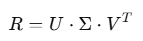


R → Original user-item rating matrix

U → User feature matrix (latent factors capturing user preferences)
Σ
Σ → Diagonal matrix of singular values (importance of features)


V^T
  → Item feature matrix (latent factors capturing item characteristics)
By keeping only the top k singular values, SVD reduces noise and reveals underlying patterns, making it an effective method for making personalized recommendations.

In [79]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
# Define rating scale (1 to 5)
reader = Reader(rating_scale=(1, 5))

# Load dataset into Surprise format
data = Dataset.load_from_df(df[['ID', 'ProdID', 'Rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
# Create SVD model

svd = SVD()

# Train model on training set
svd.fit(trainset)
predictions = svd.test(testset)

# Compute RMSE
rmse = accuracy.rmse(predictions)
print("RMSE:", rmse)



RMSE: 1.4328
RMSE: 1.432820455260396


In [81]:
from surprise import SVD
from surprise.model_selection import GridSearchCV

# Define hyperparameter search space
param_grid = {
    'n_factors': [50, 100, 150, 200],  # Number of latent factors
    'lr_all': [0.002, 0.005, 0.01, 0.02, 0.05],  # Learning rate
    'reg_all': [0.02, 0.05, 0.1, 0.15]  # Regularization strength
}

# Perform Grid Search
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)
print("All Parameter Results:")
for params, result in zip(gs.cv_results['params'], gs.cv_results['mean_test_rmse']):
    print(f"Params: {params} -> RMSE: {result:.4f}")

# Get the best parameters
best_params = gs.best_params['rmse']
print("\nBest Parameters:", best_params)

# Train the best model
svd = SVD(**best_params)
svd.fit(trainset)
predictions = svd.test(testset)

# Compute RMSE for the best model
rmse = accuracy.rmse(predictions)
print("Optimized RMSE:", rmse)


All Parameter Results:
Params: {'n_factors': 50, 'lr_all': 0.002, 'reg_all': 0.02} -> RMSE: 1.3781
Params: {'n_factors': 50, 'lr_all': 0.002, 'reg_all': 0.05} -> RMSE: 1.3755
Params: {'n_factors': 50, 'lr_all': 0.002, 'reg_all': 0.1} -> RMSE: 1.3746
Params: {'n_factors': 50, 'lr_all': 0.002, 'reg_all': 0.15} -> RMSE: 1.3733
Params: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.02} -> RMSE: 1.4069
Params: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.05} -> RMSE: 1.3941
Params: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.1} -> RMSE: 1.3857
Params: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.15} -> RMSE: 1.3823
Params: {'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0.02} -> RMSE: 1.4491
Params: {'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0.05} -> RMSE: 1.4300
Params: {'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0.1} -> RMSE: 1.4073
Params: {'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0.15} -> RMSE: 1.3939
Params: {'n_factors': 50, 'lr_all': 0.02, 'reg_all': 0.02} -> RMSE: 1.47

We successfully decrease RMSE to 1.4071, it seems that SVD is not performing better than KNN

**SVD++**

We can also try SVD++. SVD++ (Singular Value Decomposition++) is an enhanced version of SVD. It improves upon standard SVD by incorporating implicit feedback, making it more accurate for recommendation systems.

How SVD++ Works
Similar to SVD, SVD++ factorizes the user-item rating matrix into three smaller matrices:

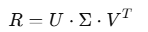



where:


U represents user preferences (latent factors).

V represents item characteristics (latent factors).

Σ contains singular values (importance of features).

In [87]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

from surprise import SVDpp

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['ID', 'ProdID', 'Rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

svdpp = SVDpp(n_factors=50, lr_all=0.02, reg_all=0.02)

svdpp.fit(trainset)
predictions = svdpp.test(testset)

# Compute RMSE
rmse = accuracy.rmse(predictions)
print("RMSE:", rmse)

RMSE: 1.4762
RMSE: 1.4762431491026455


In [88]:
from surprise import SVDpp
from surprise.model_selection import GridSearchCV
from surprise import accuracy

# Define parameter grid
param_grid = {
    'n_factors': [50, 100, 150, 200],  # Number of latent factors
    'lr_all': [0.005, 0.01, 0.02, 0.05],  # Learning rate
    'reg_all': [0.02, 0.05, 0.1, 0.15]  # Regularization strength
}

# Perform Grid Search
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
gs.fit(data)

# Print RMSE for all parameter sets
print("All Parameter Results:")
for params, result in zip(gs.cv_results['params'], gs.cv_results['mean_test_rmse']):
    print(f"Params: {params} -> RMSE: {result:.4f}")

# Get the best parameters
best_params = gs.best_params['rmse']
print("\nBest Parameters:", best_params)

# Train the best model
svdpp = SVDpp(**best_params)
svdpp.fit(trainset)
predictions = svdpp.test(testset)

# Compute RMSE for the best model
rmse = accuracy.rmse(predictions)
print("Optimized RMSE:", rmse)


All Parameter Results:
Params: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.02} -> RMSE: 1.4176
Params: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.05} -> RMSE: 1.4015
Params: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.1} -> RMSE: 1.3856
Params: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.15} -> RMSE: 1.3802
Params: {'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0.02} -> RMSE: 1.4499
Params: {'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0.05} -> RMSE: 1.4325
Params: {'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0.1} -> RMSE: 1.4094
Params: {'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0.15} -> RMSE: 1.3968
Params: {'n_factors': 50, 'lr_all': 0.02, 'reg_all': 0.02} -> RMSE: 1.4654
Params: {'n_factors': 50, 'lr_all': 0.02, 'reg_all': 0.05} -> RMSE: 1.4468
Params: {'n_factors': 50, 'lr_all': 0.02, 'reg_all': 0.1} -> RMSE: 1.4237
Params: {'n_factors': 50, 'lr_all': 0.02, 'reg_all': 0.15} -> RMSE: 1.4123
Params: {'n_factors': 50, 'lr_all': 0.05, 'reg_all': 0.02} -> RMSE: 1.4782
P

# **Best User-based Collaborative Filtering**

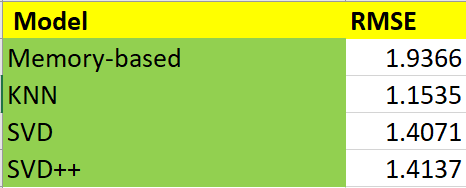

We will use KNN-based CF model with k=50 for user-based recommendation generation

In [106]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader
from surprise import KNNBasic
from collections import defaultdict

def knn_recommendations(train_data, target_user_id, k=50, top_n=10):
    """Generate top-N product recommendations for a target user using KNNBasic."""

    # Convert DataFrame to Surprise dataset format
    reader = Reader(rating_scale=(train_data['Rating'].min(), train_data['Rating'].max()))
    data = Dataset.load_from_df(train_data[['ID', 'ProdID', 'Rating']], reader)

    # Build trainset
    trainset = data.build_full_trainset()

    # Define similarity options
    sim_options = {
        "name": "cosine",
        "user_based": True,  # User-based collaborative filtering
    }

    # Train KNN model
    model = KNNBasic(k=k, sim_options=sim_options)
    model.fit(trainset)

    # Get the inner ID of the target user
    try:
        target_inner_id = trainset.to_inner_uid(target_user_id)
    except ValueError:
        print(f"User {target_user_id} not found in training data.")
        return None

    # Find k-nearest neighbors
    neighbors = model.get_neighbors(target_inner_id, k=k)

    # Get items rated by similar users
    user_ratings = defaultdict(list)
    for neighbor in neighbors:
        for item_id, rating in trainset.ur[neighbor]:
            user_ratings[item_id].append(rating)

    # Predict average rating for unrated items
    predicted_ratings = {
        item: np.mean(ratings) for item, ratings in user_ratings.items() if item not in trainset.ur[target_inner_id]
    }

    # Sort predictions and get top N recommendations
    top_recommendations = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Convert back to original item IDs
    recommended_products = [trainset.to_raw_iid(item) for item, _ in top_recommendations]

    # Fetch item details
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_products)].drop_duplicates(subset=['ProdID'])

    return recommended_items_details[['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating','Product Price']].head(top_n)

# Example usage
target_user_id = 4
collaborative_filtering_rec = knn_recommendations(df,target_user_id)
print(f"Top 10 recommendations for User {target_user_id}:")
collaborative_filtering_rec

Computing the cosine similarity matrix...
Done computing similarity matrix.
Top 10 recommendations for User 4:


,Name,ReviewCount,Brand,ImageURL,Rating,Product Price
11,"ORLY Nail Lacquer for Women, #20634 Red Carpet...",2.0,ORLY,https://i5.walmartimages.com/asr/e37d0f7d-defd...,4.5,8.50
50,"Womens Stockings, Knee High, Sheer: 15-20 mmHg...",59.0,Truform,https://i5.walmartimages.com/asr/5494cd58-75b5...,4.2,12.58
162,Pantene Pro-V Beautiful Lengths Strengthening ...,1.0,Pantene,https://i5.walmartimages.com/asr/964b1347-0ccb...,2.2,21.24
191,Schick Injector Blades Mens Razor Blade Refill...,20.0,Schick,https://i5.walmartimages.com/asr/85feda69-e804...,4.5,6.83
195,Royce Leather Executive Travel Grooming Genuin...,4.0,ROYCE New York,https://i5.walmartimages.com/asr/f0789301-6220...,4.3,54.99
447,"Burts Bees Brow Pencil, Brunette - 0.04 Ounce",66.0,Burt's Bees,https://i5.walmartimages.com/asr/d822d7d4-420e...,4.7,9.43
494,Product of Dawn Ultra Apple Blossom Antibacter...,1.0,By Dawn,https://i5.walmartimages.com/asr/c7d9d6c2-197e...,5.0,16.34
668,Kenneth Cole Vintage Black All Over Body Spray...,10.0,Kenneth Cole,https://i5.walmartimages.com/asr/fde404e6-c493...,4.9,8.85
678,Philips Norelco Electric Shaver 7500 for Sensi...,241.0,Philips Norelco,https://i5.walmartimages.com/asr/cd5409a7-e889...,4.4,118.30
937,LOreal Skin Expertise RevitaLift Complete Eye ...,3.0,L'Oreal Paris,https://i5.walmartimages.com/asr/619e9586-31f0...,3.6,30.82


# **Hybrid Model: Combine Content-based model with Collaborative Filtering**

We will combine content-based model with collaborative filtering to generate more robust recommendations. Recall that content-based model requires user to input an desired item, while collaborative filtering takes a user profile to generate recommendations according to cosine-similarity.

To do this, we simply merge outputs generated by both models, then prioritize rows with duplicates, sort them first, and then remove duplicates.
Finally, return only 10 recommendations.

In [129]:
def hybrid_recommendations(train_data,target_user_id, item_name, top_n=20):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = knn_recommendations(train_data,target_user_id, 10)

    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec])
    hybrid_rec['Duplicate_Count'] = hybrid_rec.duplicated(subset=['Name'], keep=False).astype(int)
    hybrid_rec = hybrid_rec.sort_values(by='Duplicate_Count', ascending=False)
    hybrid_rec = hybrid_rec.drop_duplicates(subset=['Name']).drop(columns=['Duplicate_Count'])
    return hybrid_rec.head(top_n)

In [132]:
target_user_id = 110 # Change this to the user_id you want recommendations for
item_name = "Creed Love In Black Hair And Body Wash 6.8oz/200ml New In Box"  # Change this to the item name
hybrid_rec = hybrid_recommendations(df,target_user_id, item_name, top_n=20)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec


Computing the cosine similarity matrix...
Done computing similarity matrix.
Top 10 Hybrid Recommendations for User 110 and Item 'Creed Love In Black Hair And Body Wash 6.8oz/200ml New In Box':


,Name,ReviewCount,Brand,ImageURL,Rating,Product Price
4004,Dermalogica Conditioning Body Wash Pro 32 oz (...,1.0,Dermalogica,https://i5.walmartimages.com/asr/74486e21-a298...,5.0,69.39
4513,"Ahava Natural Dead Sea Mud Gift Box, 13.6 Oz",1.0,Ahava,https://i5.walmartimages.com/asr/cf65dfb4-5e5f...,5.0,12.90
1069,"Anbesol Liquid Maximum Strength, 0.41 oz",124.0,Anbesol,https://i5.walmartimages.com/asr/ab29882e-b1db...,4.7,6.74
828,"Arm & Hammer Plus OxiClean Fresh Scent, 106 Lo...",440.0,Arm & Hammer,https://i5.walmartimages.com/asr/37713107-580d...,4.8,NaN
647,Earth Friendly Hand Soap - Ecos - Lemongrass -...,1.0,Earth Friendly,https://i5.walmartimages.com/asr/6652ca59-d7e8...,1.7,28.23
487,"SheaMoisture Bar Soap Raw Shea Butter, 8 oz",137.0,SheaMoisture,https://i5.walmartimages.com/asr/7401885d-7a9b...,3.7,4.18
394,Theraworx Protect U-PAK 60ct wipes and 3.4 fl ...,327.0,Theraworx,https://i5.walmartimages.com/asr/35bec421-bf66...,4.7,18.96
311,First Quality Bladder Control Pad Prevail Dail...,1.0,Prevail,https://i5.walmartimages.com/asr/6a360038-4699...,4.3,8.47
107,"Babyganics Mineral-Based Sunscreen Lotion, SPF...",67.0,BabyGanics,https://i5.walmartimages.com/asr/120d23ac-1392...,4.5,8.67
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,Bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0,47.30


In [131]:
target_user_id = 10 # Change this to the user_id you want recommendations for
item_name = 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum'

hybrid_rec = hybrid_recommendations(df,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Computing the cosine similarity matrix...
Done computing similarity matrix.
Top 10 Hybrid Recommendations for User 10 and Item 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum':


,Name,ReviewCount,Brand,ImageURL,Rating,Product Price
4872,"L.A. Colors Matte Lipstick, Torrid Matte",8.0,L.A. Colors,https://i5.walmartimages.com/asr/62d6d9fa-eee1...,4.8,3.95
896,"Black Radiance Perfect Tone Lip Color, Vintage...",78.0,Black Radiance,https://i5.walmartimages.com/asr/485f26b4-a19a...,4.7,2.49
3704,Weber Q-1200 Portable Gas Grill,2237.0,Weber,https://i5.walmartimages.com/asr/3a88232e-7a8e...,4.7,209.00
2016,(2 Pack) Hello Naturally Friendly Blue Raspber...,59.0,Hello,https://i5.walmartimages.com/asr/1f8b98f4-98de...,4.8,7.98
1649,Sally Hansen Hard As Nails Xtreme Wear Nail Co...,1873.0,Sally Hansen,https://i5.walmartimages.com/asr/466282c1-a5fd...,1.0,2.97
432,Retinol Cream Anti Wrinkle Moisturizer - Clini...,55.0,Tree of Life Beauty,https://i5.walmartimages.com/asr/6f37985c-59ca...,4.6,13.95
193,"Revlon ColorStay Skinny Liquid Liner, 304 Gree...",70.0,Revlon,https://i5.walmartimages.com/asr/aa3b20a6-3d6d...,4.5,7.41
27,9 Types Women Reusable Washable Panty Liner Ba...,1.0,Hilitand,https://i5.walmartimages.com/asr/dbfd76a2-cd16...,4.1,8.11
20,LOreal Paris Excellence Creme Permanent Triple...,6494.0,L'Oreal Paris,https://i5.walmartimages.com/asr/5ffb3626-4031...,4.0,7.91
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,Clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7,6.99
